Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.fftpack as fft
from astropy.io import fits
from scipy import optimize
from poppy import zernike
import os
import pytz

/Users/MelisaT/anaconda/lib/python3.6/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/Users/MelisaT/anaconda/lib/python3.6/site-packages/pysynphot/locations.py:329: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


Variables

In [2]:
outD = 7.77010            # primary diameter (m)
inD = 1.024               # inner M2 diameter (m)
n = 48                    # number sample points across the screen (Not the number of subapertures)
nacross = 48              # number of subapertures across the aperture
pscale = outD/(nacross)   # pixel size (m) of samples in pupil plane

make the aperture

In [3]:
#  Aperture containing zeros
x = np.linspace(-(n)/2,(n)/2,n)*pscale 
y = np.linspace(-(n)/2,(n)/2,n)*pscale
mg = np.meshgrid(x,y)
ar = np.sqrt(np.sum((m**2 for m in mg)))
ap_outer = (ar <= outD/2)
ap_inner = (ar <= inD/2)   
ap = (ap_outer ^ ap_inner).astype(int)

#  Aperture containing nans
ap_nan = np.copy(ap.astype(np.float))  
ap_nan[np.where(ap==0)] = np.nan

make frequency grid

In [4]:
kx = fft.fftshift(fft.fftfreq(n,pscale))
ky = fft.fftshift(fft.fftfreq(n,pscale))
mg = np.meshgrid(kx,ky)
kr = np.sqrt(np.sum((m**2 for m in mg))) 

Get the filename list

In [5]:
rootdir = "/Users/MelisaT/Documents/Research/GPIDomeSeeing/data/Reduced/"

In [6]:
fname_list = list()
name_list = list()

for root, dirs, files in os.walk(rootdir):
    for name in files:
        (base,ext) = os.path.splitext(name)
        if ext in ('.fits') and base[0]=='a':
            full_name = os.path.join(root,name)
            fname_list.append(full_name)  
            name_list.append(name)

In [7]:
df = pd.DataFrame({'path':[],'filename':[],'whenstr':[],'slope':[]})
df['path'] = fname_list
df['filename'] = name_list

Analysis functions

In [33]:
def radialProfile(image, center=None):
    """
    Calculate the avearge radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    ## Calculate the indices from the image
    y,x = np.indices((image.shape)) # first determine radii of all pixels
    
    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])
     
    r = np.hypot(x - center[0], y - center[1]).astype(np.int) 
    
    n = np.bincount(r.ravel())
    sy = np.bincount(r.ravel(), image.ravel())
    mean = sy/n
    
    return mean

def implot(image, display=True, **kwargs):
    """Plot an image with colorbar.
    
    image - The 2d image
    kwargs - settings for curstomizing plot"""

    ## Create matplotlib figure 
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    cax = ax.imshow(image, cmap = plt.cm.Greys, origin='lower', interpolation='none')
    cbar = fig.colorbar(cax, orientation='vertical')

    ## Modify plot based on keyword arguments
    if 'title' in kwargs: ax.set_title(kwargs['title'], fontsize=24)
    if 'xlabel' in kwargs: ax.set_xlabel(kwargs['xlabel'], fontsize=16)
    if 'ylabel' in kwargs: ax.set_ylabel(kwargs['ylabel'], fontsize=16)
    if 'cbar_label' in kwargs: cbar.set_label(kwargs['cbar_label'], 
                                              fontsize=18)
    if 'save_image' in kwargs: plt.savefig(kwargs['save_image'])

    if display: plt.show()
        
def PSDplot(psd, f, whenstr, filebase, low_bound = 0., up_bound = 2.5, display=False, **kwargs):

    fig = plt.figure(figsize=[10,7])
    ax = fig.add_subplot(111)

    def func(x, a, b):
        return a+(b*x) 
    
    par,pcov = optimize.curve_fit(func,np.log10(freq[(freq > low_bound) & (freq < up_bound)]),
                                  np.log10(psd[(freq > low_bound) & (freq < up_bound)]), p0=(1, -3.5))
    slope = par[0]
    intercept = par[1]
    
    ## Plot original PSD and linear fit
    img = ax.loglog((freq[(freq > low_bound) & (freq < up_bound)]),(psd[(freq > low_bound) & (freq < up_bound)]),
                    'b.',(freq[(freq > low_bound) & (freq < up_bound)]),
                    10**(func(np.log10(freq[(freq > low_bound) & (freq < up_bound)]),*par)), 'r')

    ax.legend(['PSD', 'slope = {0:.2f}, intercept={1:.2f}'.format(slope, intercept)],loc=3, fontsize=10)
    ax.minorticks_on()
    ax.grid(b=True, which='major', color='black', linestyle='-')
    #ax.set_ylabel(r'$\mathrm{{PSD}} \,\, [\mu\mathrm{{m}}^2/\mathrm{{Hz}}]$', fontsize=24)
    #ax.set_xlabel(r'$f$ $\mathrm{[Hz]}$', fontsize=24)
    ax.set_title(whenstr, fontsize=30, y=1.04)
    ax.set_ylabel('Power Spectrum')
    ax.set_xlabel('Spatial Frequency')
    
    ## Modify plot based on keyword arguments
    if 'title' in kwargs: ax.set_title(kwargs['title'], fontsize=10)
    if 'xlabel' in kwargs: ax.set_xlabel(kwargs['xlabel'], fontsize=15)
    if 'ylabel' in kwargs: ax.set_ylabel(kwargs['ylabel'], fontsize=15)
    if display: plt.show()
    
    filename = "{0}_PSD{1}.png".format(filebase, whenstr)
    plt.savefig(filename)
    plt.close(fig)

    return slope, intercept
    

Run analysis

In [32]:
n=0
for file in df.loc[0:2,'path']:
    
    hdulist = fits.open(file,memmap=True)
    df.loc[n,'whenstr'] = hdulist[0].header['whenstr']
    
    phase = hdulist[0].data.astype('float')
    timesteps, phx, phy = phase.shape            # contains a datacube
    avg_phase = np.nanmean(phase*ap_nan,axis=0)  # used to find average zernikes 
    
    # remove zernikes form cube
    z_basis = zernike.zernike_basis_faster(nterms= 6, npix = 48)
    z_coeff = zernike.opd_expand_nonorthonormal(avg_phase, aperture=ap, nterms=6)
    thin_lens = np.sum(z_coeff[:,None,None]*z_basis[:,:,:],axis=0)

    c_phase = (phase - thin_lens[None,:,:])*ap_nan
    c_phase[np.isnan(c_phase)]=0.
    print('Done removing zernikes')
    
    # computer fourier transform of cube
    phFT = np.zeros((timesteps,phx,phy), dtype=complex)
    for t in np.arange(timesteps):
        phFT[t,:,:] = fft.fftshift(fft.fft2(c_phase[t,:,:]))/ap.sum()
    print('Done with FT')
    
    
    # compute 2d psd cube
    psd2D = np.zeros((timesteps, phx, phy),dtype=float)
    for k in np.arange(phx):
        for l in np.arange(phy):
            psd2D[:,k,l] = np.abs(phFT[:,k,l])**2
    avg_psd2D = np.mean(psd2D, axis=0)
    print('Done with PSD')    
    
    # compute radial average of 2d psd cube and frequency
    avg_psd1D =  radialProfile(avg_psd2D)
    freq = radialProfile(kr)
    
    # compute slope of power law
    #slope, intercept = PowerLawFit(avg_psd1D,freq)
    
    outdir = '/Users/MelisaT/Documents/Research/GPIDomeSeeing/data/sp_psd/'
    date = df.loc[n,'whenstr']
    # Plot spectrum
    slope, intercept = PSDplot(avg_psd1D, freq, whenstr=date, filebase=outdir)
    
    df.loc[n,'slope'] = slope
    n=n+1

/Users/MelisaT/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


Done removing zernikes
Done with FT
Done with PSD
Done removing zernikes
Done with FT
Done with PSD
Done removing zernikes
Done with FT
Done with PSD


In [34]:
df

,filename,path,slope,whenstr
0,aored_When_2016.2.27_0.2.8_poldm_phase.fits,/Users/MelisaT/Documents/Research/GPIDomeSeein...,-2.840514,20160227000208
1,aored_When_2016.2.27_0.22.47_poldm_phase.fits,/Users/MelisaT/Documents/Research/GPIDomeSeein...,-3.021779,20160227002247
2,aored_When_2016.2.27_0.24.32_poldm_phase.fits,/Users/MelisaT/Documents/Research/GPIDomeSeein...,-3.025143,20160227002432
3,aored_When_2016.2.27_0.25.19_poldm_phase.fits,/Users/MelisaT/Documents/Research/GPIDomeSeein...,-2.937768,20160227002519
4,aored_When_2016.2.27_0.26.55_poldm_phase.fits,/Users/MelisaT/Documents/Research/GPIDomeSeein...,-2.889285,20160227002655
5,aored_When_2016.2.27_0.26.7_poldm_phase.fits,/Users/MelisaT/Documents/Research/GPIDomeSeein...,-2.855905,20160227002607
6,aored_When_2016.2.27_0.29.52_poldm_phase.fits,/Users/MelisaT/Documents/Research/GPIDomeSeein...,NaN,NaN
7,aored_When_2016.2.27_0.3.28_poldm_phase.fits,/Users/MelisaT/Documents/Research/GPIDomeSeein...,NaN,NaN
8,aored_When_2016.2.27_0.39.17_poldm_phase.fits,/Users/MelisaT/Documents/Research/GPIDomeSeein...,NaN,NaN
9,aored_When_2016.2.27_0.4.42_poldm_phase.fits,/Users/MelisaT/Documents/Research/GPIDomeSeein...,NaN,NaN


In [30]:
df['dts'] = pd.to_datetime(df['whenstr'].values,yearfirst = True)
df['dts'] = df['dts'] = df['dts'].dt.tz_localize(pytz.UTC)

In [41]:
df['dts'].dt.day.values

array([27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
       27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
       27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 29, 29,
       29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29])

<IPython.core.display.Javascript object>


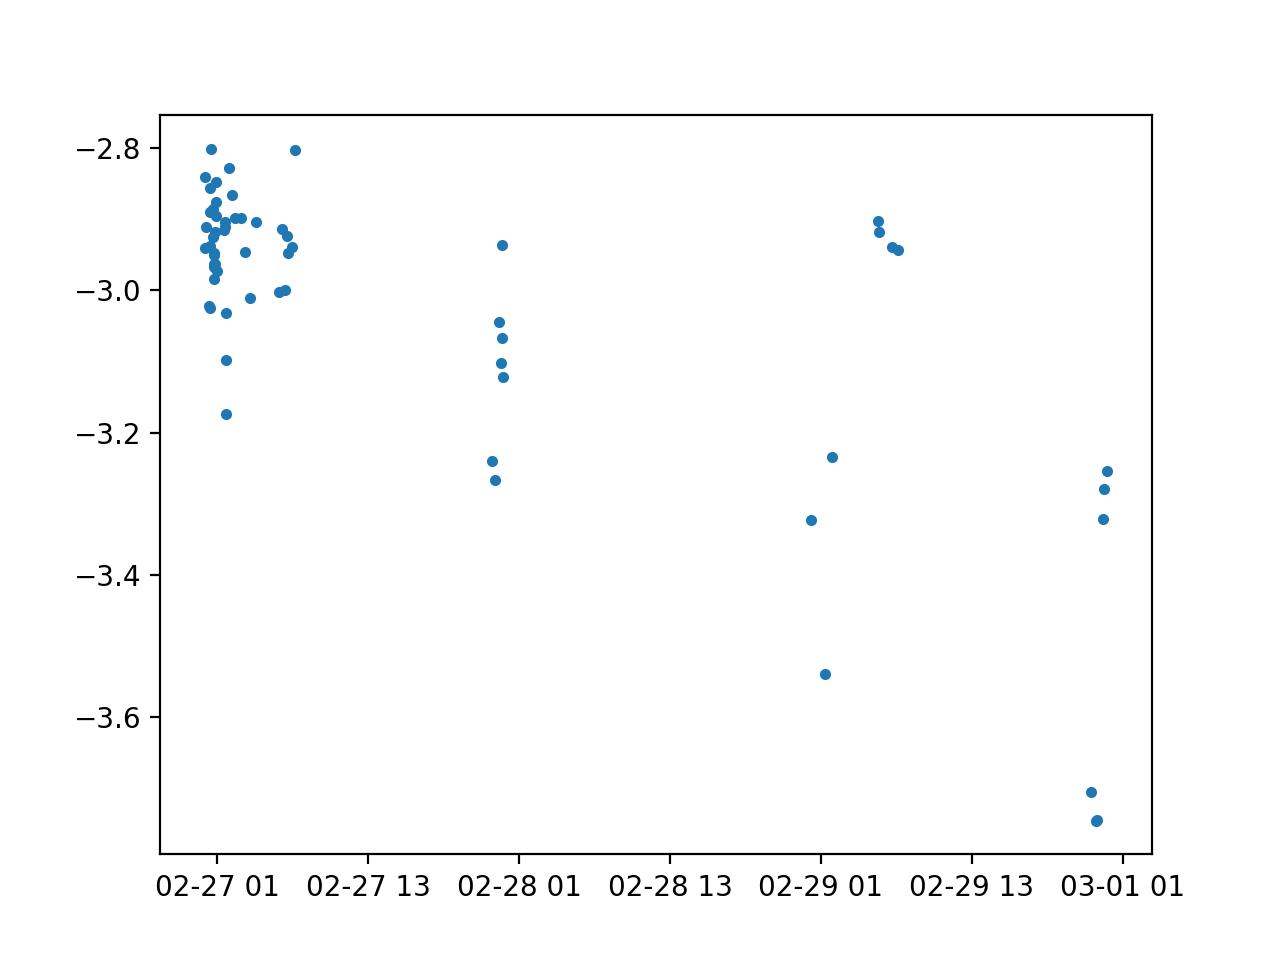

In [47]:
%matplotlib notebook
plt.figure(1)
plt.plot(df['dts'].values,df['slope'],'.')